In [35]:
import numpyro
import jax.numpy as jnp
import numpyro.distributions as dist
from jax.random import PRNGKey
import matplotlib.pyplot as plt
import haiku as hk
from numpyro.handlers import seed, trace

In [2]:
import os

In [3]:
os.chdir('../protein_dmm/')

In [4]:
from numpyro.contrib.module import haiku_module
from src.networks import BiEmitterVM

In [5]:
sample_key = PRNGKey(0)

2023-08-08 14:26:32.430232: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [57]:
def dgp(n_data):
    emitter = haiku_module(
            "model_emitter",
            hk.transform(
                BiEmitterVM(
                    hid_dim=8,
                ),
            ),
            input_shape=(200, 4),
        )
    latent_dim = 4
    latent_loc = jnp.zeros((n_data, latent_dim))
    latent_scale = jnp.ones((n_data, latent_dim))
    with numpyro.plate("data", n_data, dim=-1):
        latent_curr = numpyro.sample(
                    f"latents", dist.Normal(latent_loc, latent_scale).to_event(1)
                )
        phi_loc, phi_scale, psi_loc, psi_scale, corr = emitter(latent_curr)
        numpyro.deterministic("phi_loc", phi_loc)
        numpyro.deterministic("phi_scale", phi_scale)
        numpyro.deterministic("psi_loc", psi_loc)
        numpyro.deterministic("psi_scale", psi_scale)
        numpyro.deterministic("corr", corr)
        phi_psi = numpyro.sample(
                    "phi_psi",
                    dist.SineBivariateVonMises(
                        phi_loc*10,
                        psi_loc*10,
                        phi_scale*100,
                        psi_scale*100,
                        #weighted_correlation=corr,
                        correlation=corr*jnp.sqrt(phi_scale*psi_scale),
                    ),
                )
    return phi_psi

In [58]:
n_data = 1000

In [59]:
data = trace(seed(dgp, 0)).get_trace(1000)

In [60]:
data.keys()

odict_keys(['model_emitter$params', 'data', 'latents', 'phi_loc', 'phi_scale', 'psi_loc', 'psi_scale', 'corr', 'phi_psi'])

In [61]:
data['phi_scale']['value'].shape

(1000, 1)

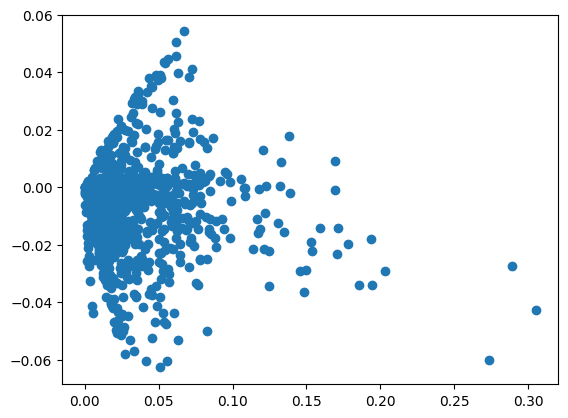

In [62]:
plt.scatter(data['phi_loc']['value'], data['psi_loc']['value'])

In [63]:
foo = data['phi_psi']['value']

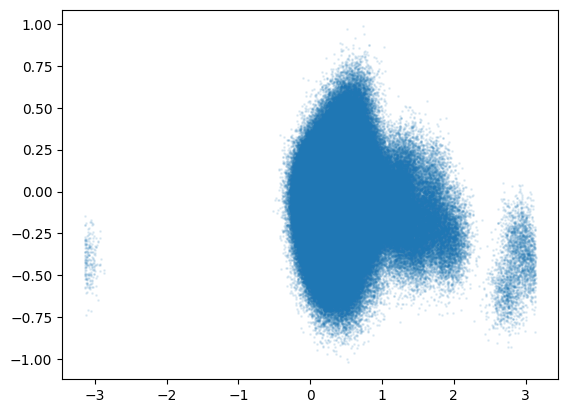

In [64]:
plt.scatter(*foo.T, alpha=0.1, s=1)